#用随机梯度下降处理回归

本主题将介绍随机梯度下降法（Stochastic Gradient Descent，SGD），我们将用它解决回归问题，后面我们还用它处理分类问题。

<!-- TEASER_END -->

##Getting ready

SGD是机器学习中的无名英雄（unsung hero），许多算法的底层都有SGD的身影。之所以受欢迎是因为其简便与快速——处理大量数据时这些都是好事儿。

SGD成为许多机器学习算法的核心的另一个原因是它很容易描述过程。在本章的最后，我们对数据作一些变换，然后用模型的损失函数（loss function）拟合数据。

##How to do it...

如果SGD适合处理大数据集，我们就用大点儿的数据集来演示：

In [5]:
from sklearn import datasets
X, y = datasets.make_regression(int(1e6))
print("{:,}".format(int(1e6)))

1,000,000


值得进一步了解数据对象的构成和规模信息。还在我们用的是NumPy数组，所以我们可以获得`nbytes`。Python本身没有获取NumPy数组大小的方法。输出结果与系统有关，你的结果和下面的数据可能不同：

In [9]:
print("{:,}".format(X.nbytes))

800,000,000


我们把字节码`nbytes`转换成MB（megabytes），看着更直观：

In [10]:
X.nbytes / 1e6

800.0

因此，每个数据点的字节数就是：

In [11]:
X.nbytes / (X.shape[0] * X.shape[1])

8.0

这些信息和我们的目标没多大关系，不过了解数据对象的构成和规模信息还是值得的。

现在，我们有了数据，就用`SGDRegressor`来拟合：

In [13]:
import numpy as np
from sklearn import linear_model
sgd = linear_model.SGDRegressor()
train = np.random.choice([True, False], size=len(y), p=[.75, .25])
sgd.fit(X[train], y[train])

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

这里又出现一个“充实的（beefy）”对象。重点需要了解我们的损失函数是`squared_loss`，与线性回归里的残差平方和是一样的。还需要注意`shuffle`会对数据产生随机搅动（shuffle），这在解决伪相关问题时很有用。scikit-learn用`fit_intercept`方法可以自动加一列1。如果想从拟合结果中看到很多输出，就把`verbose`设为1。用scikit-learn的API预测，我们可以统计残差的分布情况：

In [16]:
linear_preds = sgd.predict(X[~train])

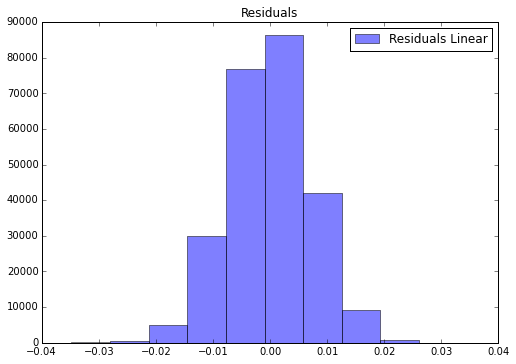

In [17]:
%matplotlib inline
from matplotlib import pyplot as plt
f, ax = plt.subplots(figsize=(7, 5))
f.tight_layout()
ax.hist(linear_preds - y[~train],label='Residuals Linear', color='b', alpha=.5);
ax.set_title("Residuals")
ax.legend(loc='best');

拟合的效果非常好。异常值很少，直方图也呈现出完美的正态分布钟形图。

##How it works...

当然这里我们用的是虚拟数据集，但是你也可以用更大的数据集合。例如，如果你在华尔街工作，有可能每天一个市场都有20亿条交易数据。现在如果有一周或一年的数据，用SGD算法就可能无法运行了。很难处理这么大的数据量，因为标准的梯度下降法每一步都要计算梯度，计算量非常庞大。

标准的梯度下降法的思想是在每次迭代计算一个新的相关系数矩阵，然后用学习速率（learning rate）和目标函数（objective function）的梯度调整它，直到相关系数矩阵收敛为止。如果用伪代码写就是这样：

```
while not_converged:
    w = w – learning_rate * gradient(cost(w))
```

这里涉及的变量包括：

- `w`：相关系数矩阵
- `learning_rate`：每次迭代时前进的长度。如果收敛效果不好，调整这个参数很重要
- `gradient`：导数矩阵
- `cost`：回归的残差平方和。后面我们会介绍，不同的分类方法中损失函数定义不同，具有可变性也是SGD应用广泛的理由之一。

除了梯度函数有点复杂之外，这个方法还是可以的。随着相关系数向量的增加，梯度的计算也会变得越来越慢。每次更新之前，我们都需要对每个数据点计算新权重。

SGD的工作方式稍有不同；每次迭代不是批量更新梯度，而是只更新新数据点的参数。这些数据点是随机选择的，因此称为随机梯度下降法。